# Bayesian Optimization

Imagine you need to find the best settings for a complex system – perhaps tuning the hyperparameters of a deep learning model, optimizing the design (projekt) of an experiment, or finding the ideal parameters for a simulation. Often, evaluating the system with a given set of parameters (i.e., running the experiment or training the model) is expensive, time-consuming, or resource-intensive (zasobochłonne). How can you find the optimal settings without performing an exhaustive search?

This is where **Bayesian Optimization (BO)** comes in (wkracza). It's a powerful, sequential strategy designed specifically for the **global optimization of black-box functions**. These are functions where:

1.  We don't know the underlying (bazowy) mathematical form (it's a "black box").
2.  Evaluating the function (getting an output `y` for an input `x`) is costly.
3.  We often cannot compute derivatives (pochodnych) (gradients).
4.  The observations might be noisy (the output `y` can vary even for the same input `x`).

BO tackles (radzi sobie) this challenge by intelligently choosing the next point to evaluate, aiming (stara się) to find the optimum (maximum or minimum) in as few evaluations as possible.

### Core Components 

Bayesian Optimization cleverly (sprytnie) balances exploring unknown parts of the search space and exploiting areas known to yield (dają) good results. It does this using two main components:

1.  **A Probabilistic Surrogate Model:** This model approximates the unknown objective function based on the points observed so far. It also provides uncertainty estimates (oszacowania niepewności) about the function's behavior in unexplored regions. Gaussian Processes (GPs) are the most common choice for this surrogate model due to their flexibility (elastyczność) and inherent (wbudowaną) uncertainty quantification (szacowanie).
2.  **An Acquisition Function:** This function uses the surrogate model's predictions (mean and uncertainty) to determine (aby określić) the 'utility' (użyteczność) of evaluating any given point in the search space. It guides (kieruje) the search by suggesting the point that is most likely to lead to an improvement, considering both the predicted performance and the uncertainty. Examples include Expected Improvement (EI) and Upper Confidence Bound (UCB).

### The Iterative Process

The BO algorithm works iteratively:

1.  **Observe:** Evaluate the black-box function at one or more points chosen by the acquisition function.
2.  **Update:** Update the surrogate model (e.g., the Gaussian Process) using all the data collected so far (inputs and their observed outputs).
3.  **Select:** Optimize the acquisition function (which is cheap to evaluate) over the search space to find the most promising point(s) to evaluate next.
4.  **Repeat:** Continue this cycle until a stopping criterion is met (e.g., budget of function evaluations exhausted, desired (pożądany) performance level reached).


### Recommended reading:
1. [A Tutorial on Bayesian Optimization](https://arxiv.org/pdf/1807.02811)
1. [BayesOpt docs](https://bayesian-optimization.github.io/BayesianOptimization/2.0.3/)
1. [Exploring Bayesian Optimization](https://distill.pub/2020/bayesian-optimization/)
1. [Acquisition functions in Bayesian Optimization](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)
1. [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)
1. [Practical Bayesian Optimization of Machine Learning Algorithms](https://arxiv.org/abs/1206.2944)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from bayes_opt import BayesianOptimization
from bayes_opt import acquisition

# Set random seed for reproducibility
np.random.seed(42)

### Define and visualize the target function
First, we'll create a synthetic objective function to optimize. This specific function has three peaks (at x=0, x≈2 and x≈6) and is a toy example.

$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}$$

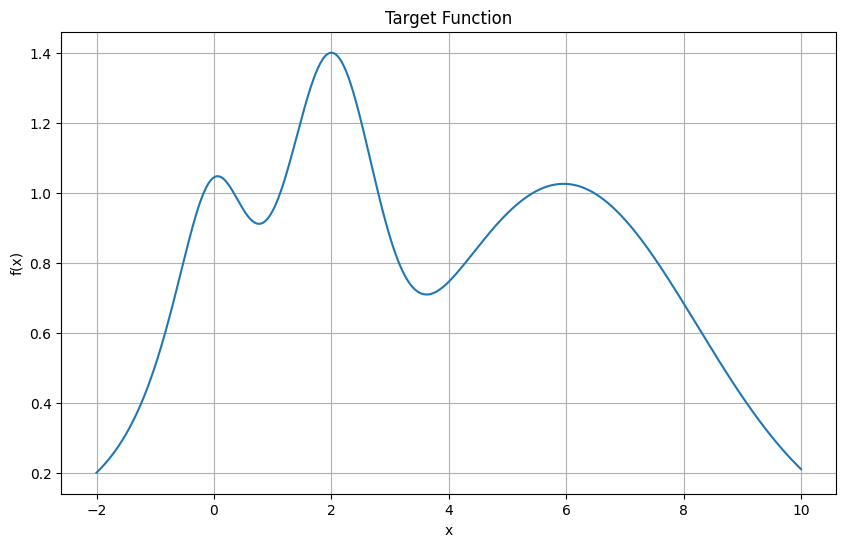

In [8]:
def target_function(x):
    """Our example target function to be optimized"""
    return np.exp(-((x - 2) ** 2)) + np.exp(-((x - 6) ** 2) / 10) + 1 / (x**2 + 1)


x = np.linspace(-2, 10, 1000)
y = target_function(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.grid(True)
plt.title("Target Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

### Define visualization functions
These helper functions will visualize the Gaussian Process model
and acquisition function at each step of the optimization process.
They help us understand how the model evolves as more observations (w miarę) are made.

In [4]:
def posterior(optimizer, grid):
    """Get posterior mean and standard deviation from GP model"""
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y, save_path=None):
    """Plot the Gaussian Process model, observations, and acquisition function"""
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        f"Gaussian Process and Utility Function After {steps} Steps",
        fontsize=30,
    )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])

    optimizer.acquisition_function._fit_gp(optimizer._gp, optimizer._space)
    mu, sigma = posterior(optimizer, x)

    axis.plot(x, y, linewidth=3, label="Target")
    axis.plot(
        x_obs.flatten(), y_obs, "D", markersize=8, label="Observations", color="r"
    )
    axis.plot(x, mu, "--", color="k", label="Prediction")

    axis.fill(
        np.concatenate([x, x[::-1]]),
        np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=0.6,
        fc="c",
        ec="None",
        label="95% confidence interval",
    )

    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel("f(x)", fontdict={"size": 20})
    axis.set_xlabel("x", fontdict={"size": 20})

    utility_function = optimizer.acquisition_function
    utility = -1 * utility_function._get_acq(gp=optimizer._gp)(x)
    x_flat = x.flatten()

    acq.plot(x_flat, utility, label="Utility Function", color="purple")
    acq.plot(
        x_flat[np.argmax(utility)],
        np.max(utility),
        "*",
        markersize=15,
        label="Next Best Guess",
        markerfacecolor="gold",
        markeredgecolor="k",
        markeredgewidth=1,
    )
    acq.set_xlim((-2, 10))
    acq.set_ylabel("Utility", fontdict={"size": 20})
    acq.set_xlabel("x", fontdict={"size": 20})

    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.0)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.0)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

    return fig

We'll now see Bayesian Optimization in action, step by step.
At each step, observe:
1. How the GP model (dashed (przerywana) line) is updated
2. How the confidence interval (przedział ufności) (light blue area) changes
3. How the acquisition function (purple (filoetowa) line) guides the next sample
4. Where the next sample point (gold star) is placed

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |

Step 0: Initial random points


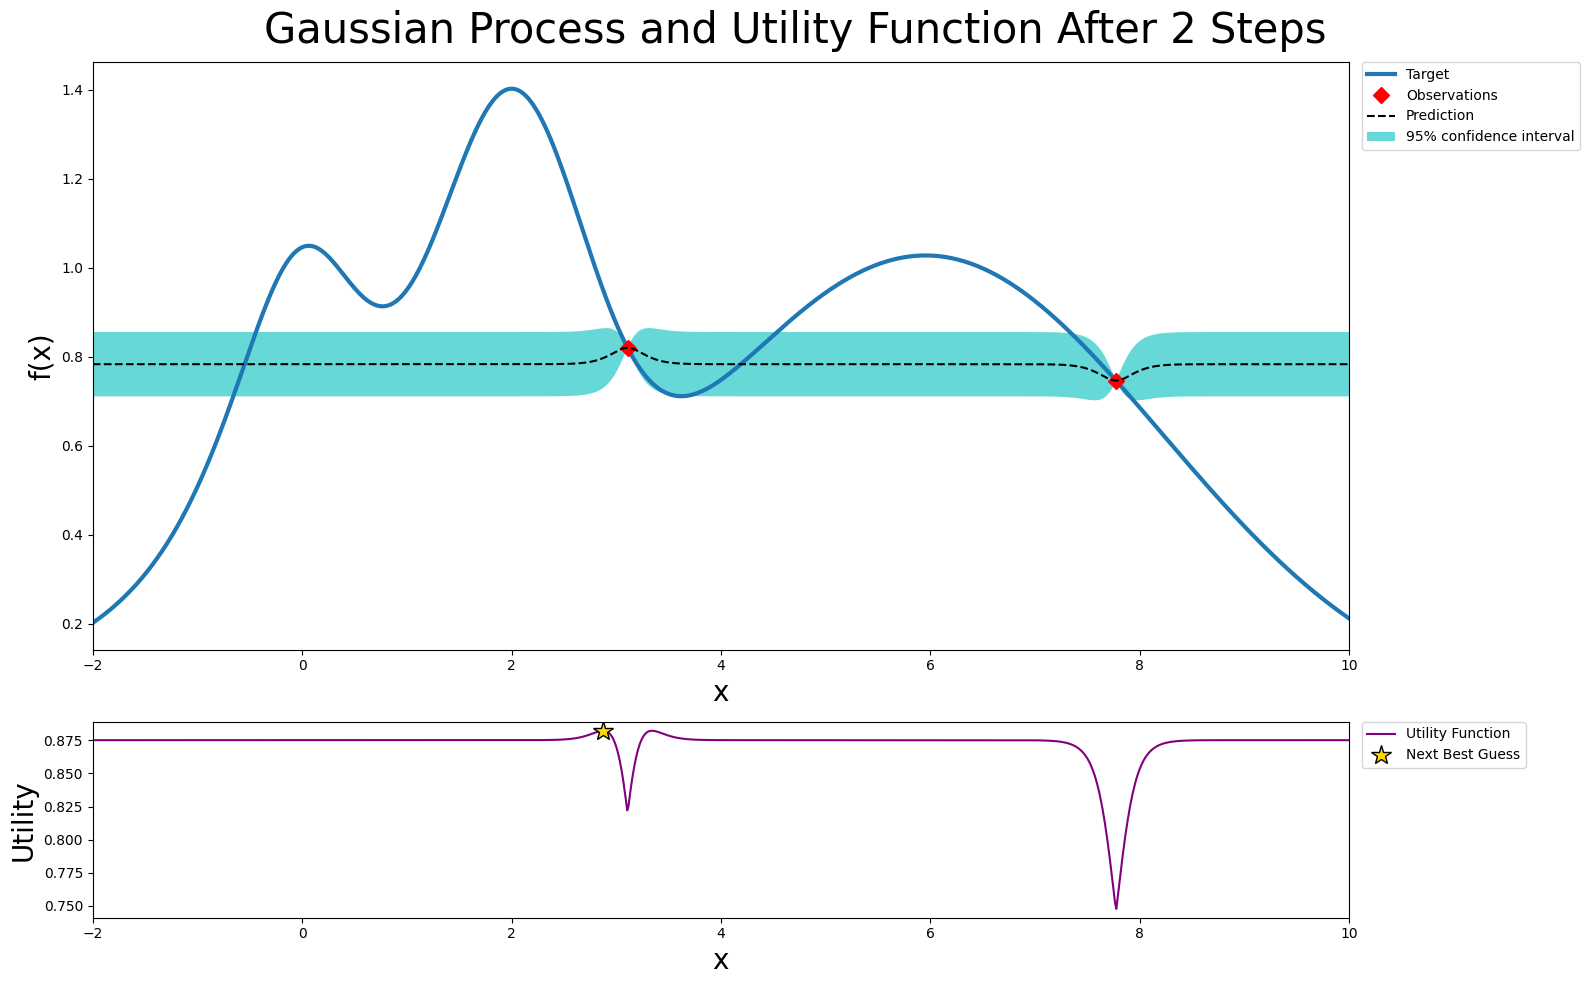

|   iter    |  target   |     x     |
-------------------------------------
| 3         | 0.3575    | -1.354    |

Step 1: Added a new observation


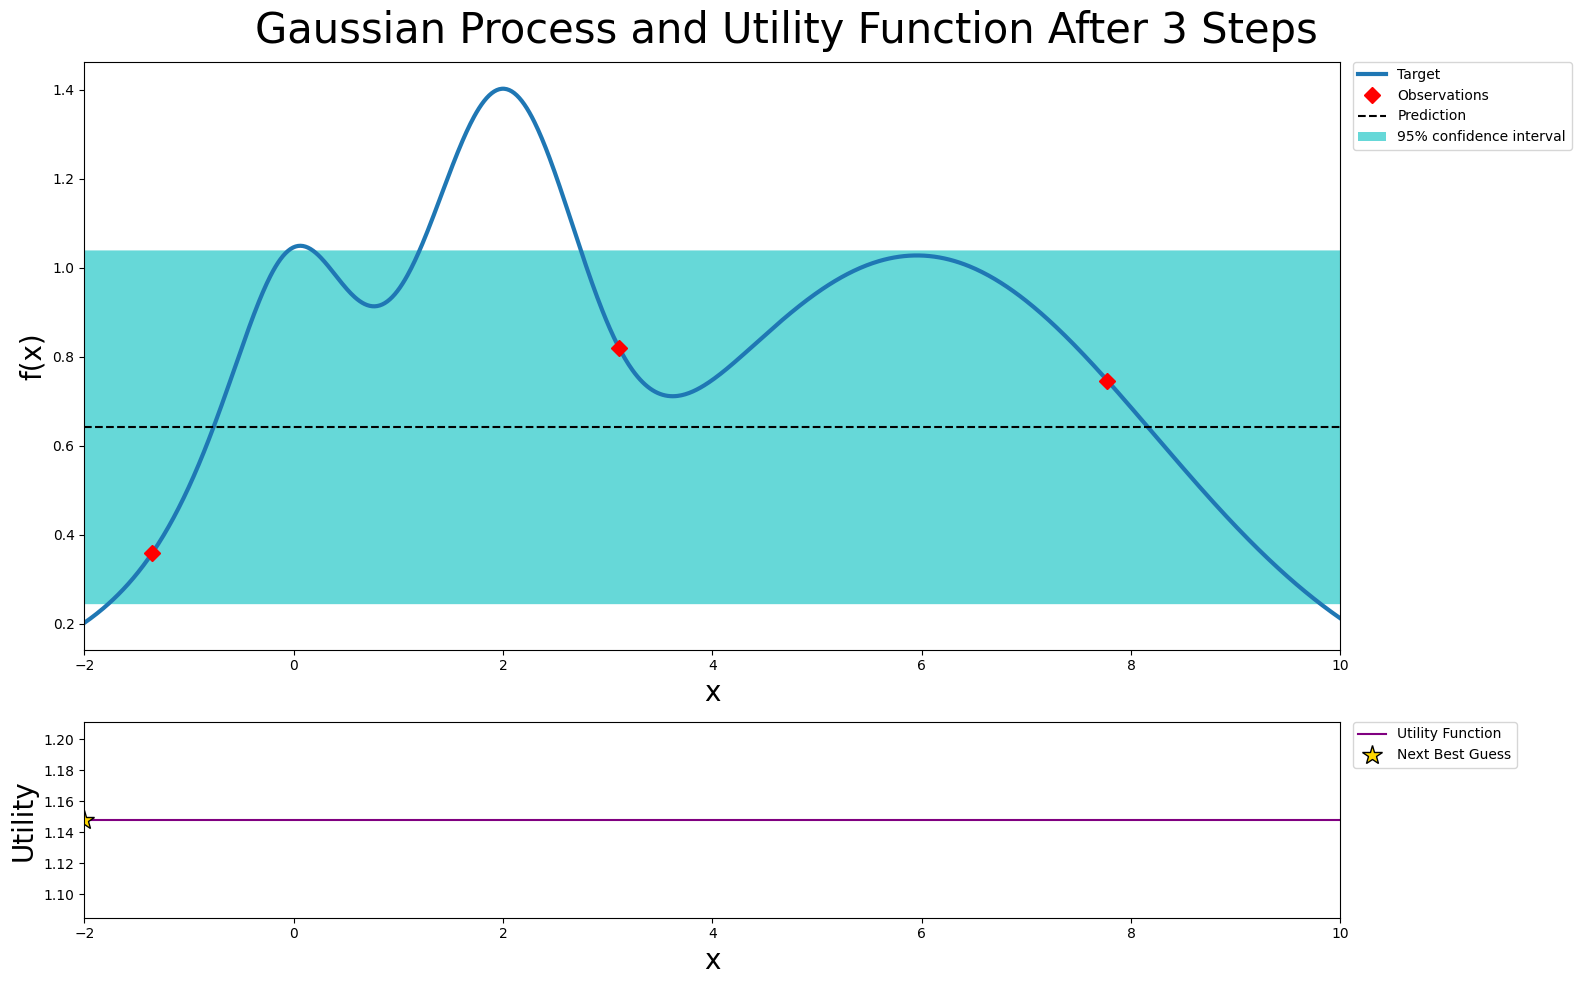

|   iter    |  target   |     x     |
-------------------------------------
| 4         | 0.8084    | 3.134     |

Step 2: Added a new observation


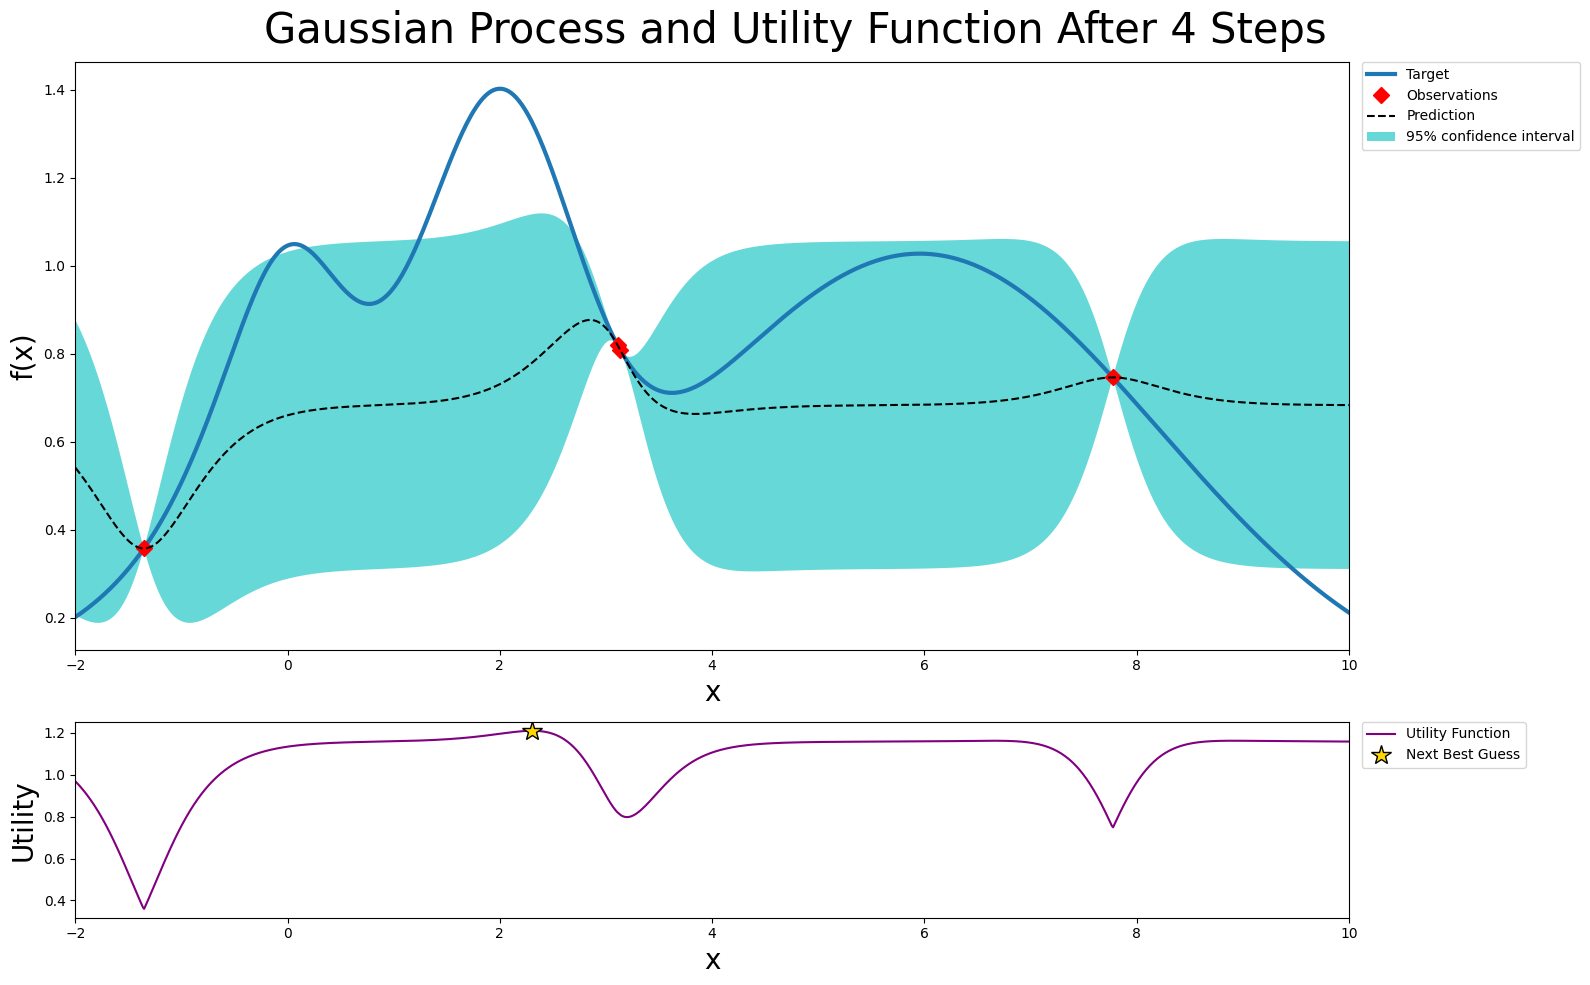

|   iter    |  target   |     x     |
-------------------------------------
| 5         | 1.325     | 2.305     |

Step 3: Added a new observation


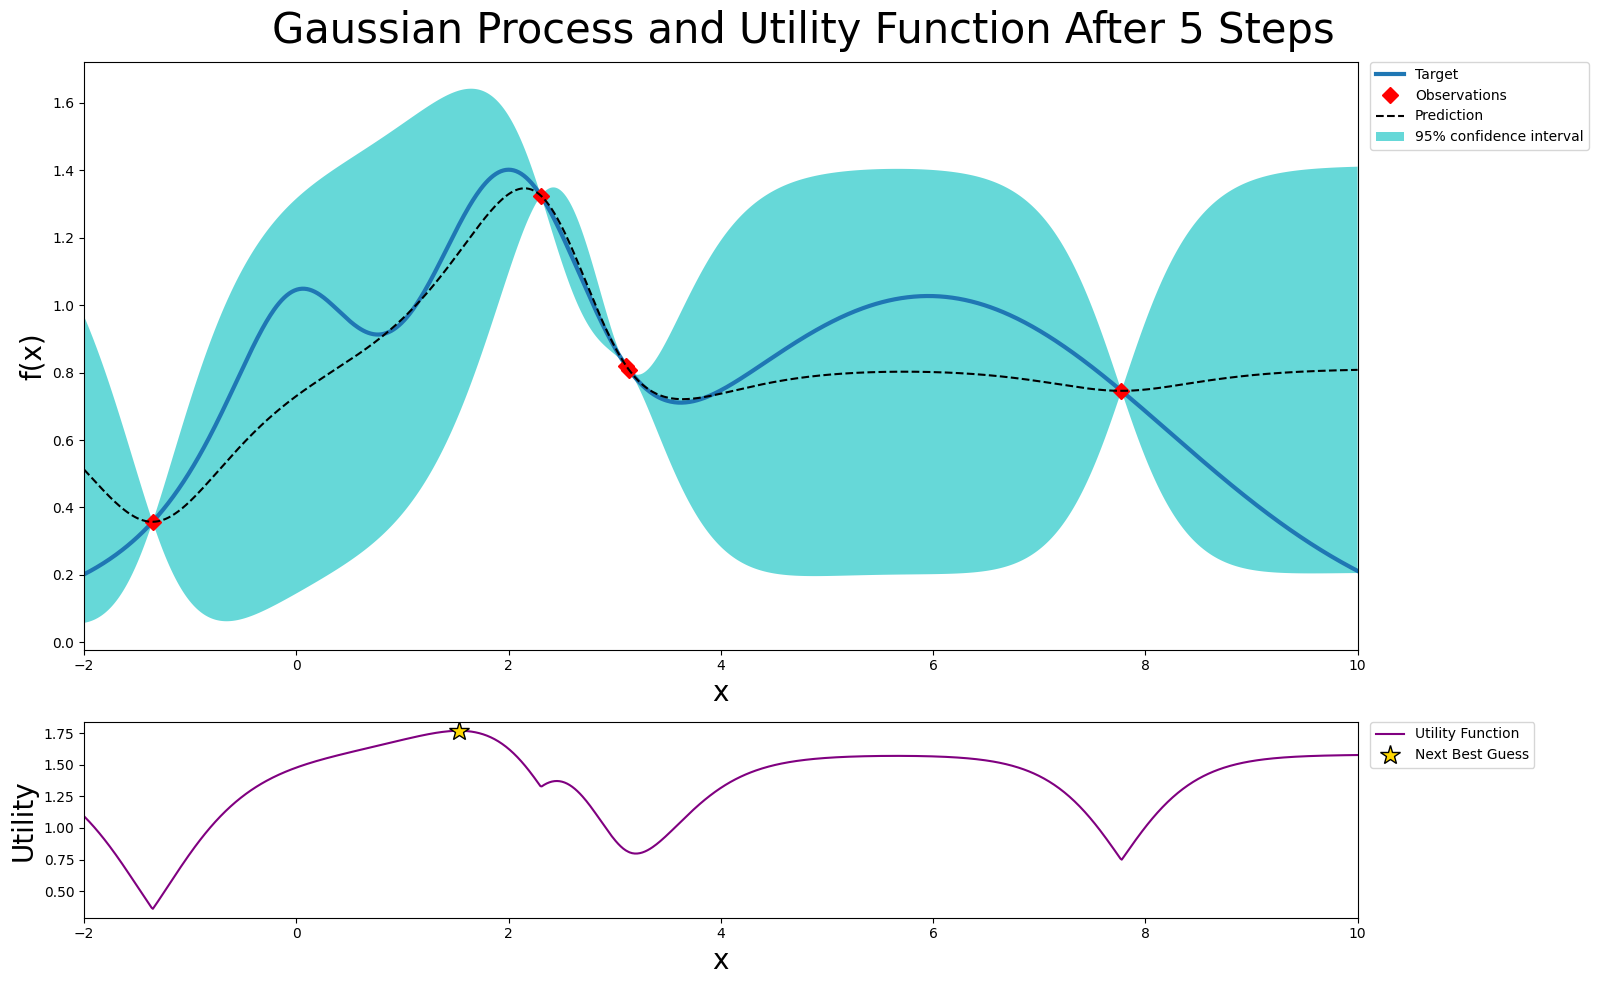

|   iter    |  target   |     x     |
-------------------------------------
| 6         | 1.238     | 1.533     |

Step 4: Added a new observation


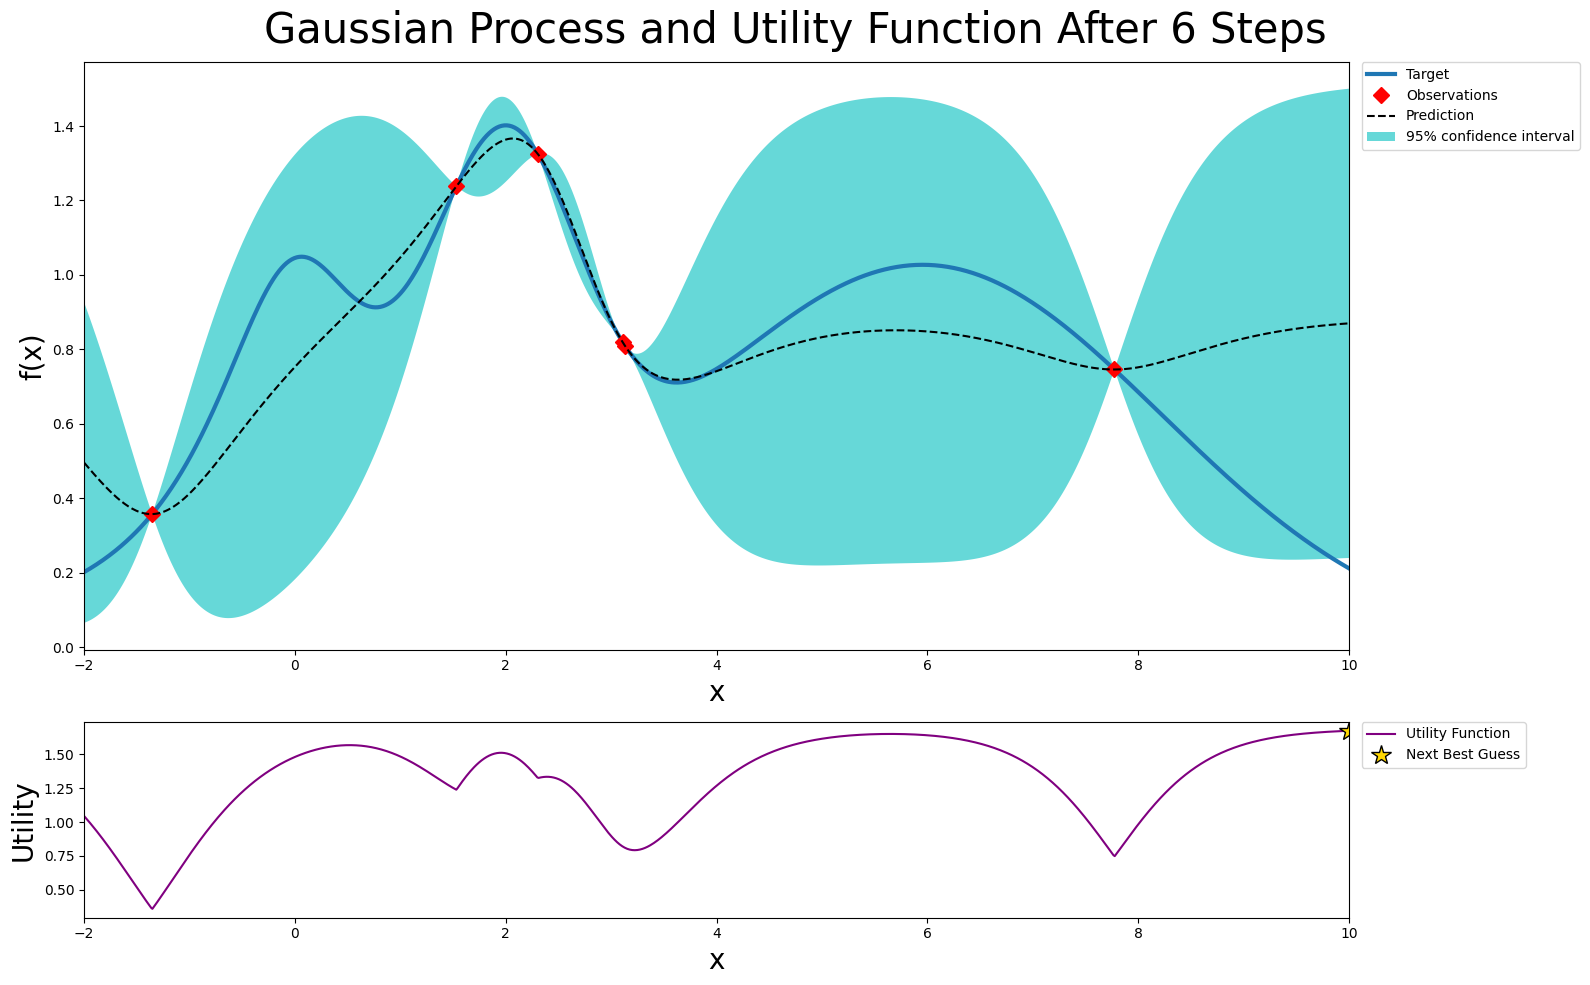

|   iter    |  target   |     x     |
-------------------------------------
| 7         | 0.212     | 9.999     |

Step 5: Added a new observation


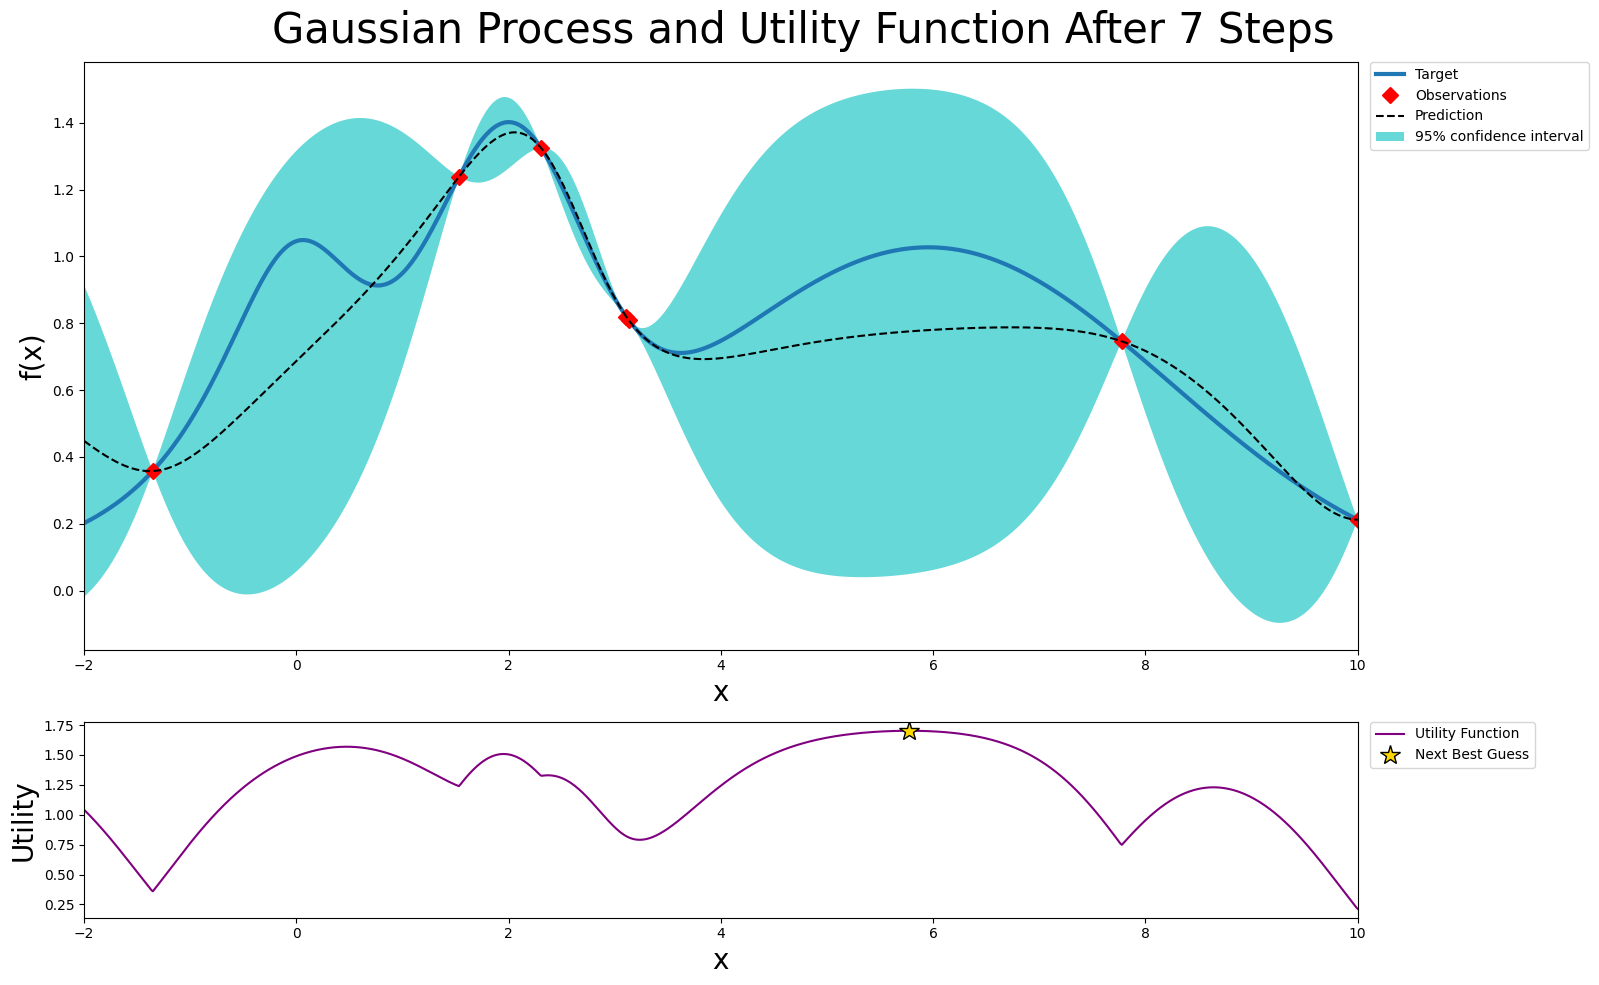


Final result:
Best target value found: 1.3246
Best input value found: x = 2.3055


In [9]:
acquisition_function = acquisition.UpperConfidenceBound(kappa=2.5)
optimizer = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=acquisition_function,
    random_state=27,
)

# Prepare data for visualization
x = np.linspace(-2, 10, 1000).reshape(-1, 1)
y = target_function(x)

# Initialize with 2 random points
optimizer.maximize(init_points=2, n_iter=0)
print("\nStep 0: Initial random points")
plot_gp(optimizer, x, y)

for i in range(1, 6):
    optimizer.maximize(init_points=0, n_iter=1)
    print(f"\nStep {i}: Added a new observation")
    plot_gp(optimizer, x, y)

print("\nFinal result:")
print(f"Best target value found: {optimizer.max['target']:.4f}")
print(f"Best input value found: x = {optimizer.max['params']['x']:.4f}")

Acquisition functions guide (sterują) the sampling process by balancing: 
- Exploitation: Sampling where the model predicts high values
- Exploration: Sampling where the model is uncertain (niepewny)

We'll compare three different acquisition functions:
1. Upper Confidence Bound (UCB): Balances exploration and exploitation
2. Probability of Improvement (PI): More exploitative
3. Greedy: Purely (czysto) exploitative (custom implementation - niestandardowa)

In [6]:
class GreedyAcquisition(acquisition.AcquisitionFunction):
    """Purely exploitative acquisition function (only considers mean)"""

    def __init__(self, random_state=None):
        super().__init__(random_state)

    def base_acq(self, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        return mean  # disregard std

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.7408    | 3.341     |
| 4         | 1.392     | 2.108     |
| 5         | 1.164     | 1.413     |
| 6         | 0.5001    | -1.015    |
| 7         | 0.2118    | 10.0      |

UCB Acquisition Function Results:


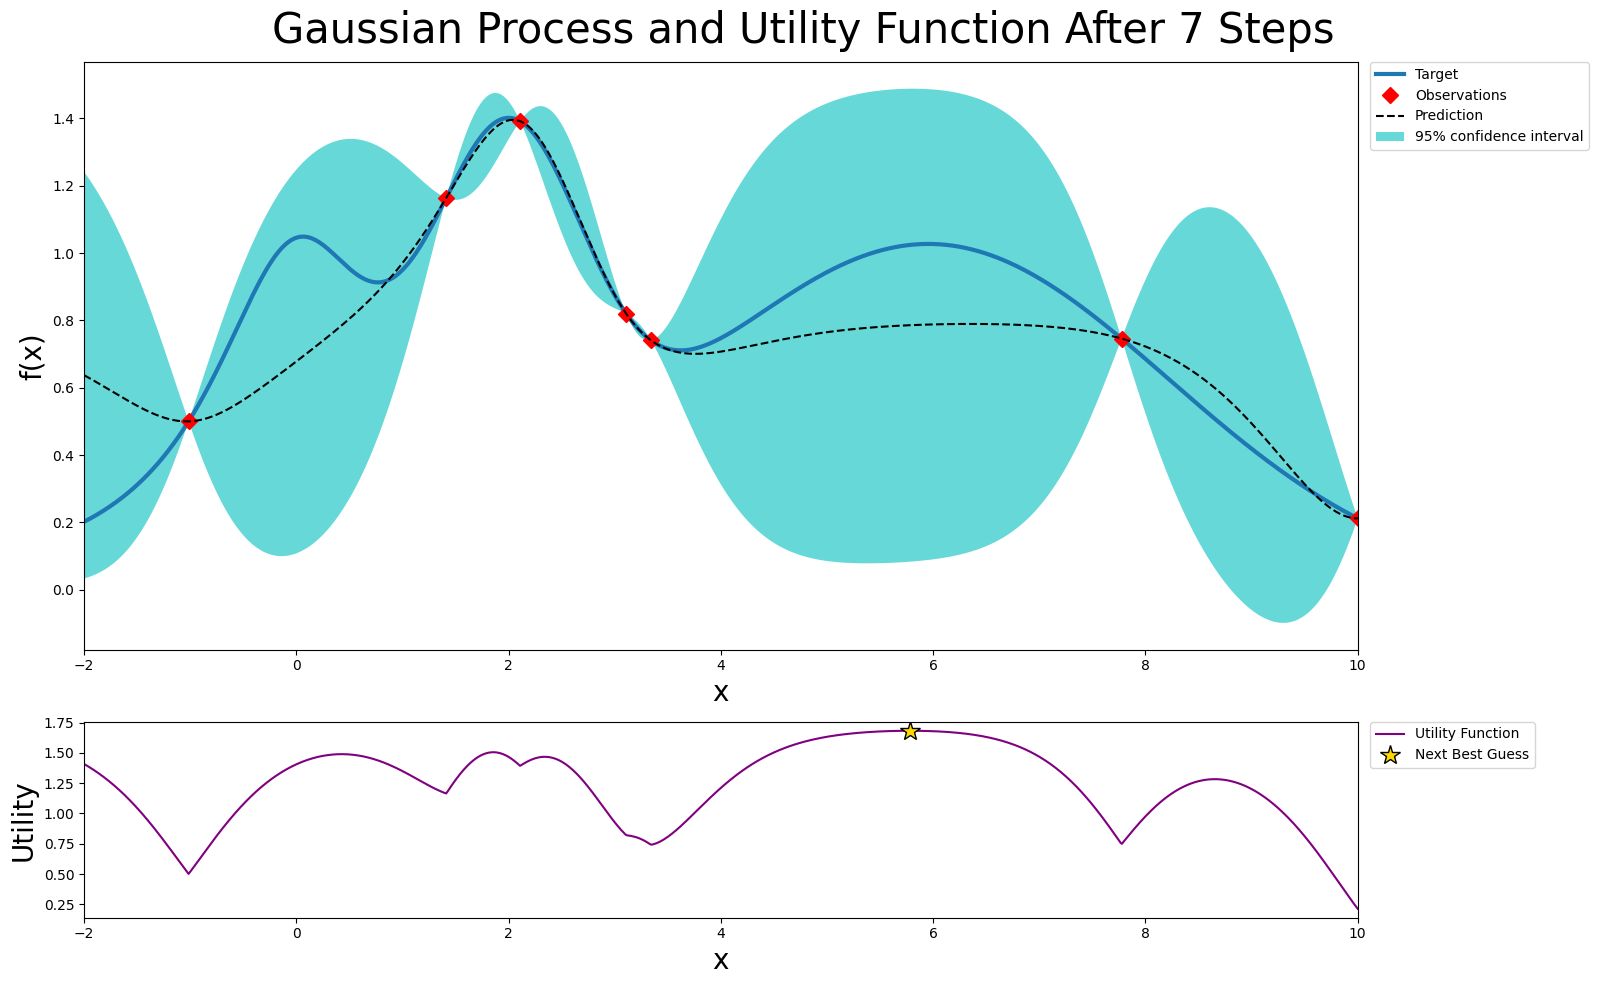

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8245    | 3.098     |
| 4         | 0.8244    | 3.099     |
| 5         | 0.8261    | 3.095     |
| 6         | 0.8309    | 3.085     |
| 7         | 0.8401    | 3.066     |

Probability of Improvement Acquisition Function Results:


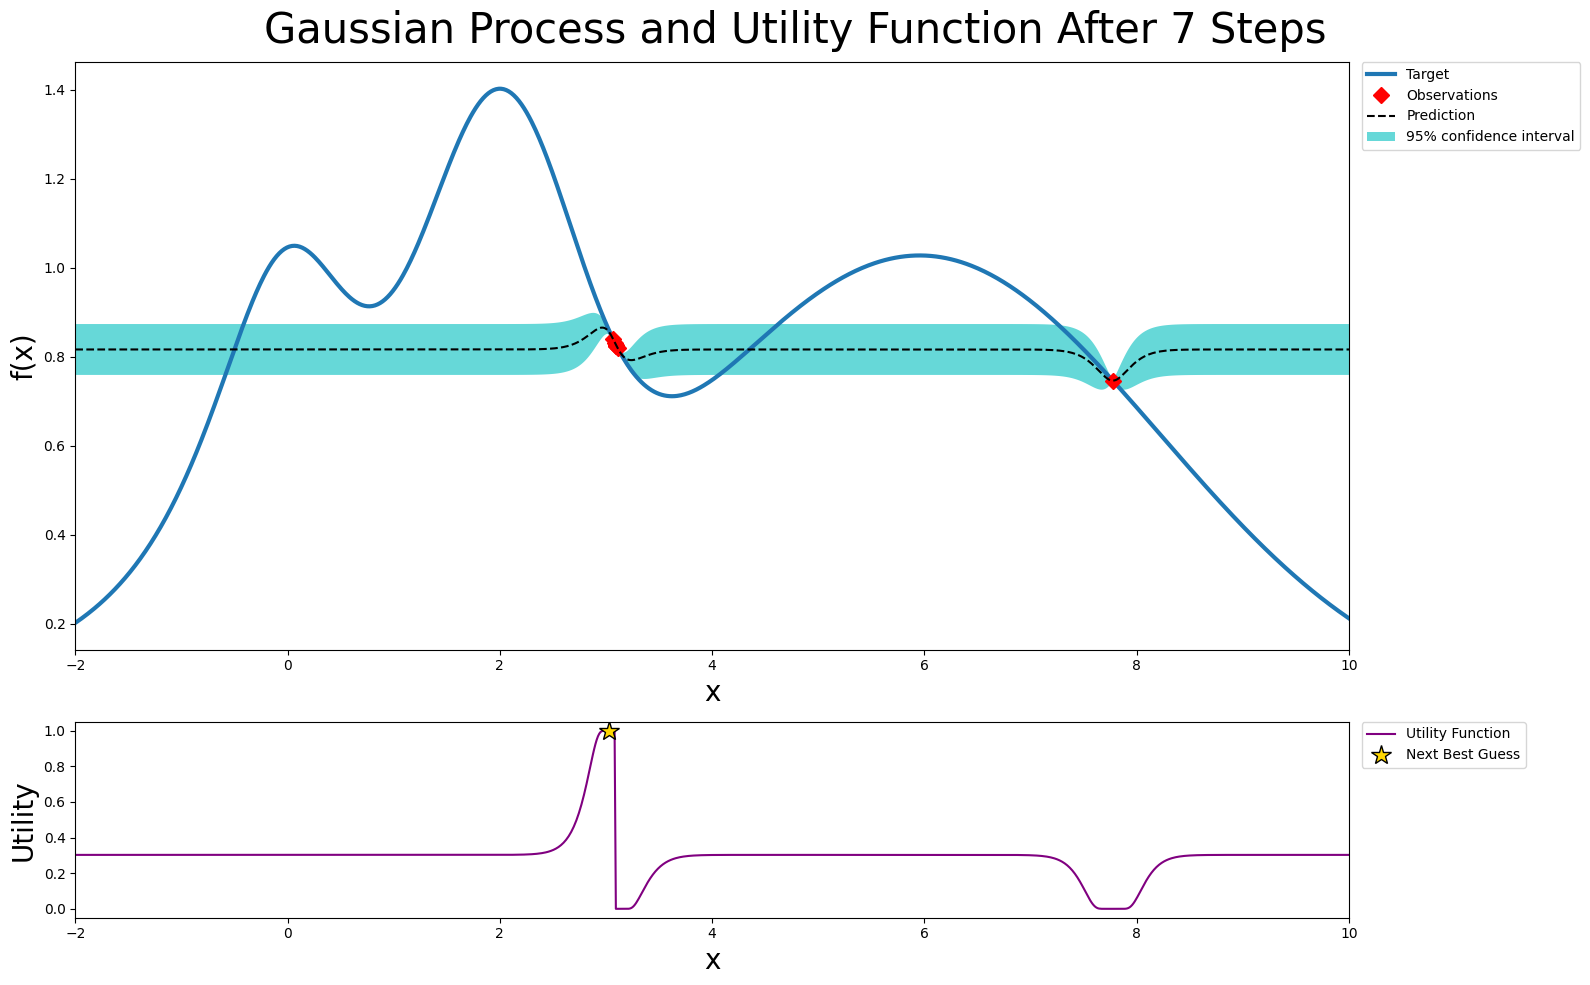

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8193    | 3.11      |
| 4         | 0.8421    | 3.062     |
| 5         | 0.8762    | 2.997     |
| 6         | 0.9255    | 2.913     |
| 7         | 0.9924    | 2.811     |

Greedy (Purely Exploitative) Acquisition Function Results:


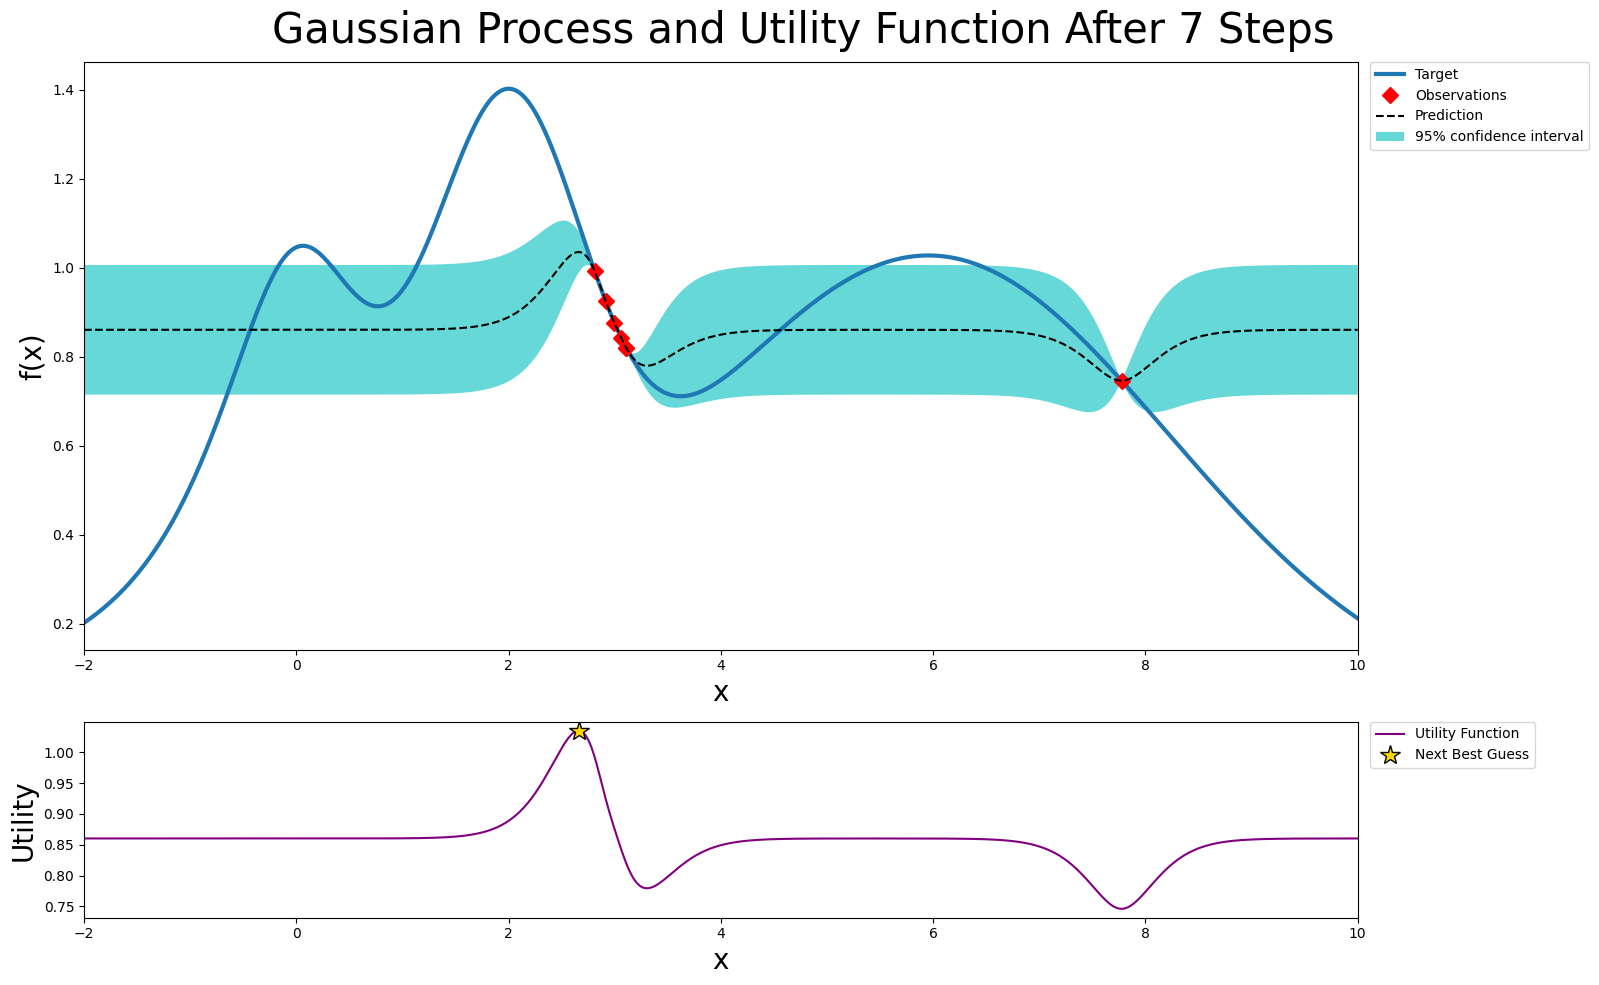


Summary of results:
UCB best value: 1.3919 at x = 2.1084
PI best value: 0.8401 at x = 3.0658
Greedy best value: 0.9924 at x = 2.8105


In [7]:
ucb = acquisition.UpperConfidenceBound(kappa=2.5)
optimizer_ucb = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ucb,
    random_state=27,
)

optimizer_ucb.maximize(init_points=2, n_iter=5)
print("\nUCB Acquisition Function Results:")
plot_gp(optimizer_ucb, x, y)

# Run with PI
pi = acquisition.ProbabilityOfImprovement(xi=1e-4)
optimizer_pi = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=pi,
    random_state=27,
)

optimizer_pi.maximize(init_points=2, n_iter=5)
print("\nProbability of Improvement Acquisition Function Results:")
plot_gp(optimizer_pi, x, y)

# Run with Greedy
greedy = GreedyAcquisition()
optimizer_greedy = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=greedy,
    random_state=27,
)

optimizer_greedy.maximize(init_points=2, n_iter=5)
print("\nGreedy (Purely Exploitative) Acquisition Function Results:")
plot_gp(optimizer_greedy, x, y)

# Summary
print("\nSummary of results:")
print(
    f"UCB best value: {optimizer_ucb.max['target']:.4f} at x = {optimizer_ucb.max['params']['x']:.4f}"
)
print(
    f"PI best value: {optimizer_pi.max['target']:.4f} at x = {optimizer_pi.max['params']['x']:.4f}"
)
print(
    f"Greedy best value: {optimizer_greedy.max['target']:.4f} at x = {optimizer_greedy.max['params']['x']:.4f}"
)

Comment these results. Write your observations in a Markdown cell.

Exercise 1: UCB
---------------

The parameter kappa in the UCB acquisition function controls the trade-off between:
- Exploration (high kappa): More emphasis on the uncertainty
- Exploitation (low kappa): More emphasis on the predicted mean 

Compare results for UCB using 3 different values:
1. kappa = 0.1 (Mostly exploitation)
2. kappa = 2.5 (Balanced)
3. kappa = 5.0 (Mostly exploration)

Review this [blog post](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html) and explain the underlying concept of UCB in a Markdown cell.

In [11]:
ucb_low = acquisition.UpperConfidenceBound(kappa=0.1)   
ucb = acquisition.UpperConfidenceBound(kappa=2.5)
ucb_high = acquisition.UpperConfidenceBound(kappa=5.0)  


optimizer_ucb_low = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ucb_low,
    random_state=27,
)
optimizer_ucb_low.maximize(init_points=2, n_iter=5)

optimizer_ucb_high = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ucb_high,
    random_state=27,
)
optimizer_ucb_high.maximize(init_points=2, n_iter=5)


optimizer_ucb = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ucb,
    random_state=27,
)
optimizer_ucb.maximize(init_points=2, n_iter=5)

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.8262    | 3.095     |
| 4         | 0.8265    | 3.094     |
| 5         | 0.8639    | 3.019     |
| 6         | 0.9009    | 2.954     |
| 7         | 0.9561    | 2.865     |
|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 1.007     | 2.79      |
| 4         | 0.6654    | 8.074     |
| 5         | 1.037     | 0.1934    |
| 6         | 1.325     | 2.305     |
| 7         | 1.177     | 1.433     |
|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.7406    | 3.342     |
| 4         | 0.5427    | 8.523     |
| 5         | 0.7406    | 3.342     |
| 6         | 1.024     | 2.765     |
| 7         

If we use a low UCB value (e.g., kappa = 0.1), the vast majority of the sample points are located very close to each other (e.g., 3.109, 3.094, 3.019, etc.).   
The best point found gives a result of approximately 0.9381. This hyperparameter setting pushes the algorithm towards exploitation, which in this case leads   
to suboptimal results.

On the other hand, when kappa is set to 5.0, the algorithm focuses more on exploration. The sample points are more dispersed and not clustered together, which  
shows the algorithm is exploring the space more broadly. However, this can sometimes prevent the algorithm from effectively capturing and exploiting promising  
regions. In this case, the best result was around 1.77, which is better than with kappa = 0.1 (0.9561).  

The best performance was observed when kappa was set to 2.5, where exploration and exploitation were balanced. The algorithm was able to both search broadly   
and refine its focus, leading to convergence towards an optimum. After 7 iterations, the best result was approximately 1.274, making it the most effective   
setting in this comparison.



Exercise 2: Chaotic Acquisition Function
-----------------------------------------
**Goal**: Implement a chaotic acquisition function that exclusively (wyłącznie) prioritizes the standard deviation of predictions, disregarding the predicted mean. Compare its performance against standard acquisition functions such as UCB and PI (Probability of Improvement).

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.3805    | -1.289    |
| 4         | 0.865     | 4.584     |
| 5         | 0.2119    | 9.999     |
| 6         | 0.9217    | 0.881     |
| 7         | 1.022     | 6.183     |


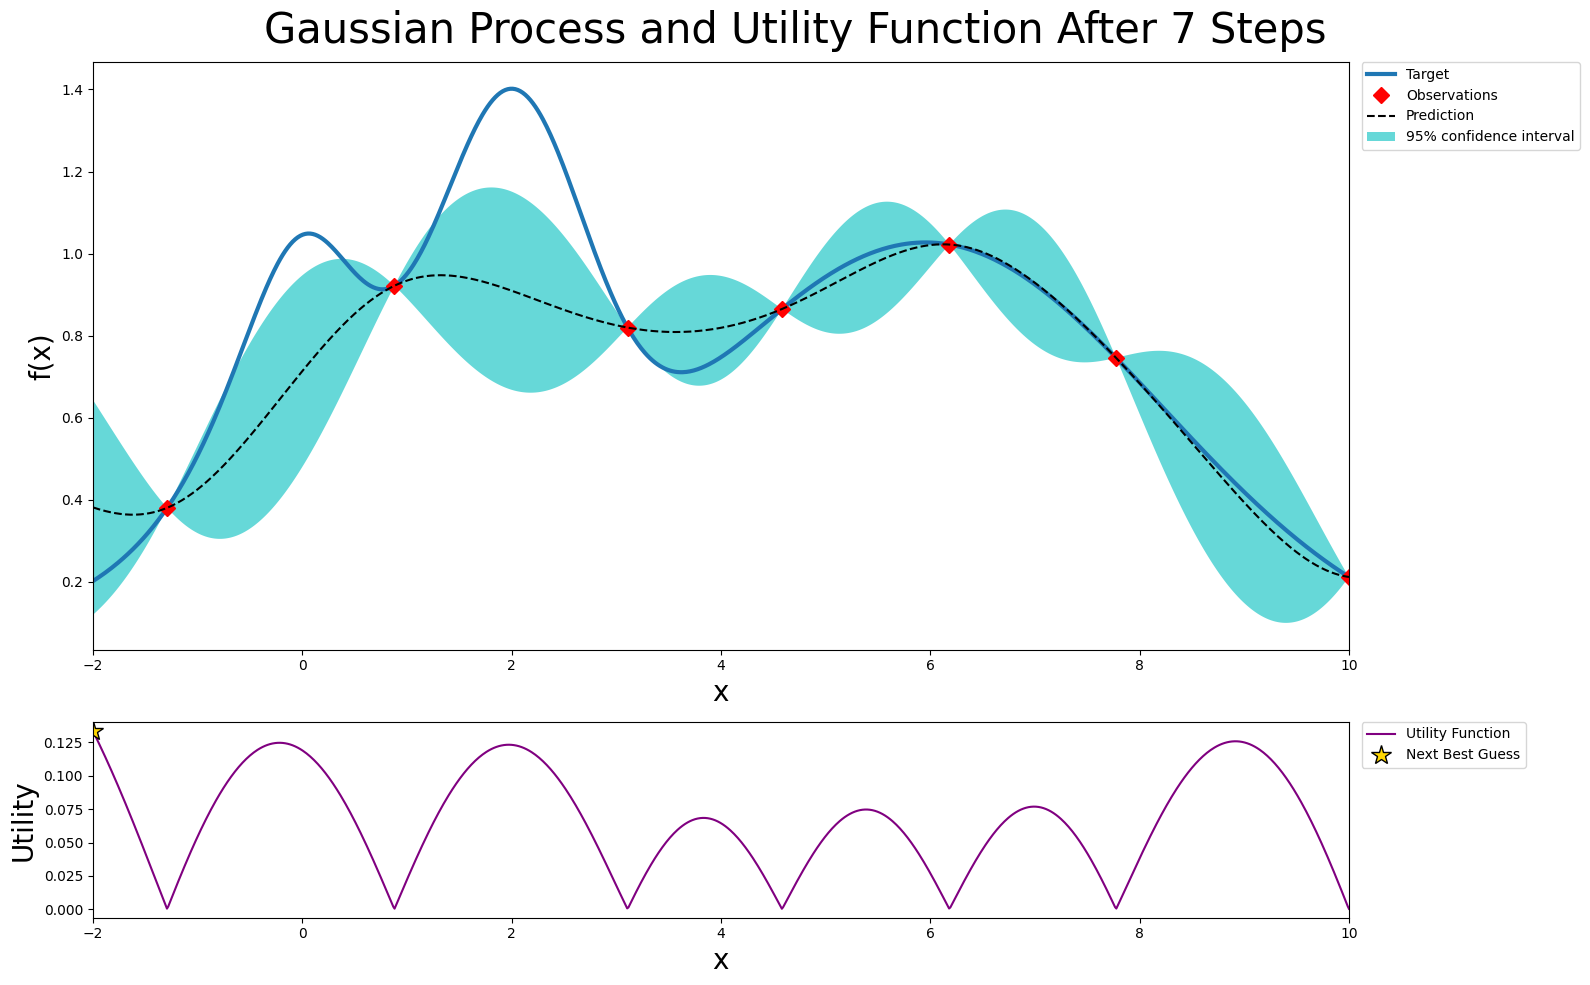

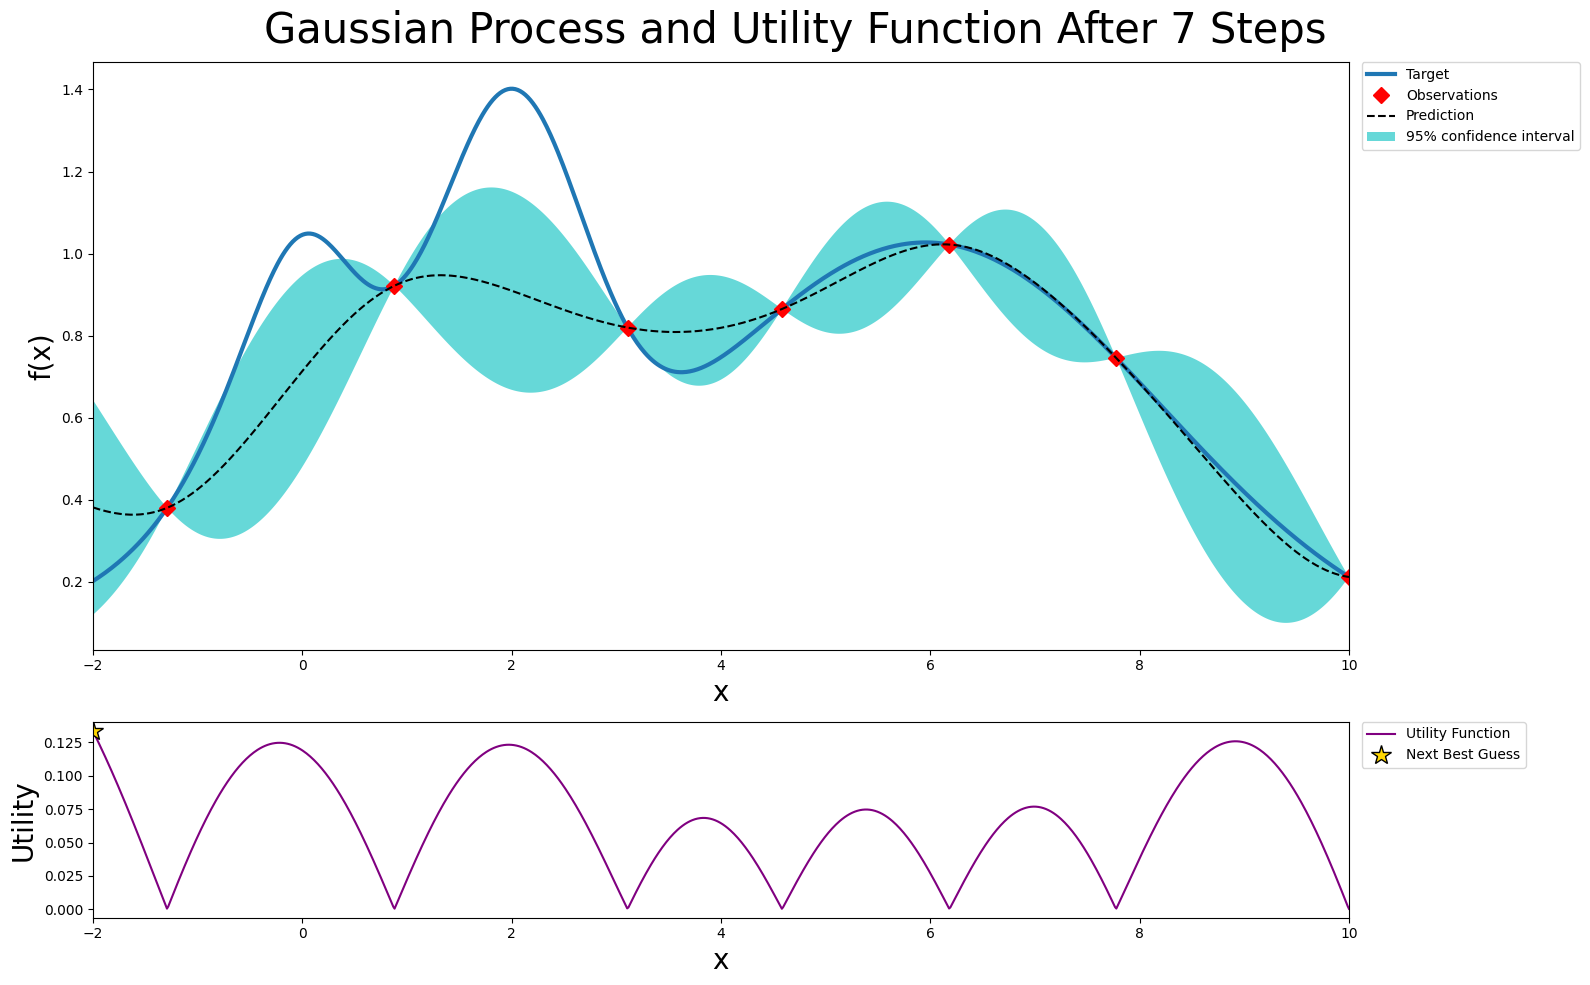

In [17]:
class ChaoticAcq(acquisition.AcquisitionFunction):
    """Chaotic acquisition: prioritizes only uncertainty (std), disregarding mean."""

    def __init__(self, random_state=None):
        super().__init__(random_state)

    def base_acq(self, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        return std  
    

chaos = ChaoticAcq()

optimizer_chaotic = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=chaos,
    random_state=27,
)

optimizer_chaotic.maximize(init_points=2, n_iter=5)


plot_gp(optimizer_chaotic, x, y)



We can see that the sample points are distributed evenly. The best score of 1.022 when using the ChaoticAcq function is not as good as the result obtained with UCB (kappa = 2.5).  
The algorithm focuses on minimizing the standard deviation and learning the shape of the function, but not on optimizing it. Points where the function's variability is high are   
sampled more densely.



Exercise 3: Expected Improvement
--------------------------------

**Goal:** Implement the Expected Improvement (EI) acquisition function by extending the `AcquisitionFunction` base class provided by the `BayesOpt` library.

Expected Improvement (EI) is a popular choice for the acquisition function. Let's understand its derivation: (wyprowadzenie)

1.  **Current Best:** After $n$ evaluations, the best function value observed *so far* is $f^* = \max_{m=1..n} f(x_m)$.

2.  **Potential Improvement:** If we evaluate a new point $x$, the *actual* improvement over the current best $f^*$ is $\max(f(x) - f^*, 0)$, sometimes written as $[f(x) - f^*]^+$.

3.  **The Challenge:** We want to choose $x$ to maximize this improvement, but $f(x)$ is unknown *before* evaluation.

4.  **The Solution: Expected Improvement:** Our probabilistic model gives a posterior distribution for $f(x)$ at any point $x$. Given the data  (biorąc pod uwagę dane), this is typically a Gaussian distribution: $f(x) \sim \mathcal{N}(\mu_n(x), \sigma_n^2(x))$. EI maximizes the *expected* value of the improvement, where the expectation is taken over (jest brana względem) this posterior distribution:

    $EI_n(x) = E_n[ \max(f(x) - f^*, 0) ]$

    This value represents, on average, how much we expect to improve upon (względem) $f^*$ by evaluating at $x$. The next point chosen is the one that maximizes $EI_n(x)$.

### Mathematical Formulation

The expected improvement integral can be computed analytically. The standard closed-form expression is:

$$
EI(x) =
\begin{cases}
(\mu(x) - f^*) \Phi(Z) + \sigma(x) \varphi(Z) & \text{if } \sigma(x) > 0 \\
0 & \text{if } \sigma(x) = 0
\end{cases}
$$

Where:

* $\mu(x)$: The posterior mean (przewidywania średnia) of $f(x)$ at point $x$.
* $\sigma(x)$: The posterior standard deviation of $f(x)$ at point $x$.
* $f^*$: The best function value observed so far (a single scalar value).
* $Z = \frac{\mu(x) - f^*}{\sigma(x)}$
* $\Phi(Z)$: The Cumulative Distribution Function (CDF) of the standard normal distribution $\mathcal{N}(0, 1)$.
* $\varphi(Z)$: The Probability Density Function (PDF) of the standard normal distribution $\mathcal{N}(0, 1)$.

### Implementation Task

Create a class `ExpectedImprovement` inheriting from (dziedziczącą po) `acquisition.AcquisitionFunction` and implement the core calculation in the `base_acq` method. The signature of `base_acq` method looks like this:
```python
def base_acq(self, mean: NDArray[Float], std: NDArray[Float]) -> NDArray[Float]:
```

Compare its performance against other acquisition functions.

Hint: Analyse the source code of `UpperConfidenceBound` class to better understand how to use/update $f^*$ (`self.y_max`).

In [29]:
from bayes_opt.acquisition import AcquisitionFunction
from scipy.stats import norm
from numpy.typing import NDArray

class ExpectedImprovement(AcquisitionFunction):
    """Expected Improvement acquisition function."""

    def __init__(self, xi: float = 0.0, random_state: int = None) -> None:
        super().__init__(random_state=random_state)
        self.xi = xi

    def base_acq(self, mean: NDArray[np.float64], std: NDArray[np.float64]) -> NDArray[np.float64]:

       
        f_max = self.y_max  
        sigma = std
        mu = mean

        with np.errstate(divide='warn'):
            Z = (mu - f_max - self.xi) / sigma
            ei = (mu - f_max - self.xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0 
        return ei
    
    def set_state(self, y_max: float):
        self.y_max = y_max


    def suggest(
    self,
    gp,
    target_space,
    n_random=10000,
    n_l_bfgs_b=10,
    fit_gp=True,
    ):
        y_max = target_space._target_max()
        if y_max is None and not target_space.empty:
            raise ValueError("""Cannot suggest a point without an allowed point. Use 
                            target_space.random_sample() to generate a point until 
                            at least one point that satisfies the constraints is found.""")
        self.y_max = y_max 
        
        x_max = super().suggest(
            gp=gp,
            target_space=target_space,
            n_random=n_random,
            n_l_bfgs_b=n_l_bfgs_b,
            fit_gp=fit_gp,
    )
        return x_max

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |
| 3         | 0.9061    | 2.945     |
| 4         | 0.7859    | 7.621     |
| 5         | 0.4314    | -1.162    |
| 6         | 1.108     | 2.647     |
| 7         | 1.305     | 2.344     |
| 8         | 1.398     | 1.931     |

Expected Improvement Acquisition Function Results:


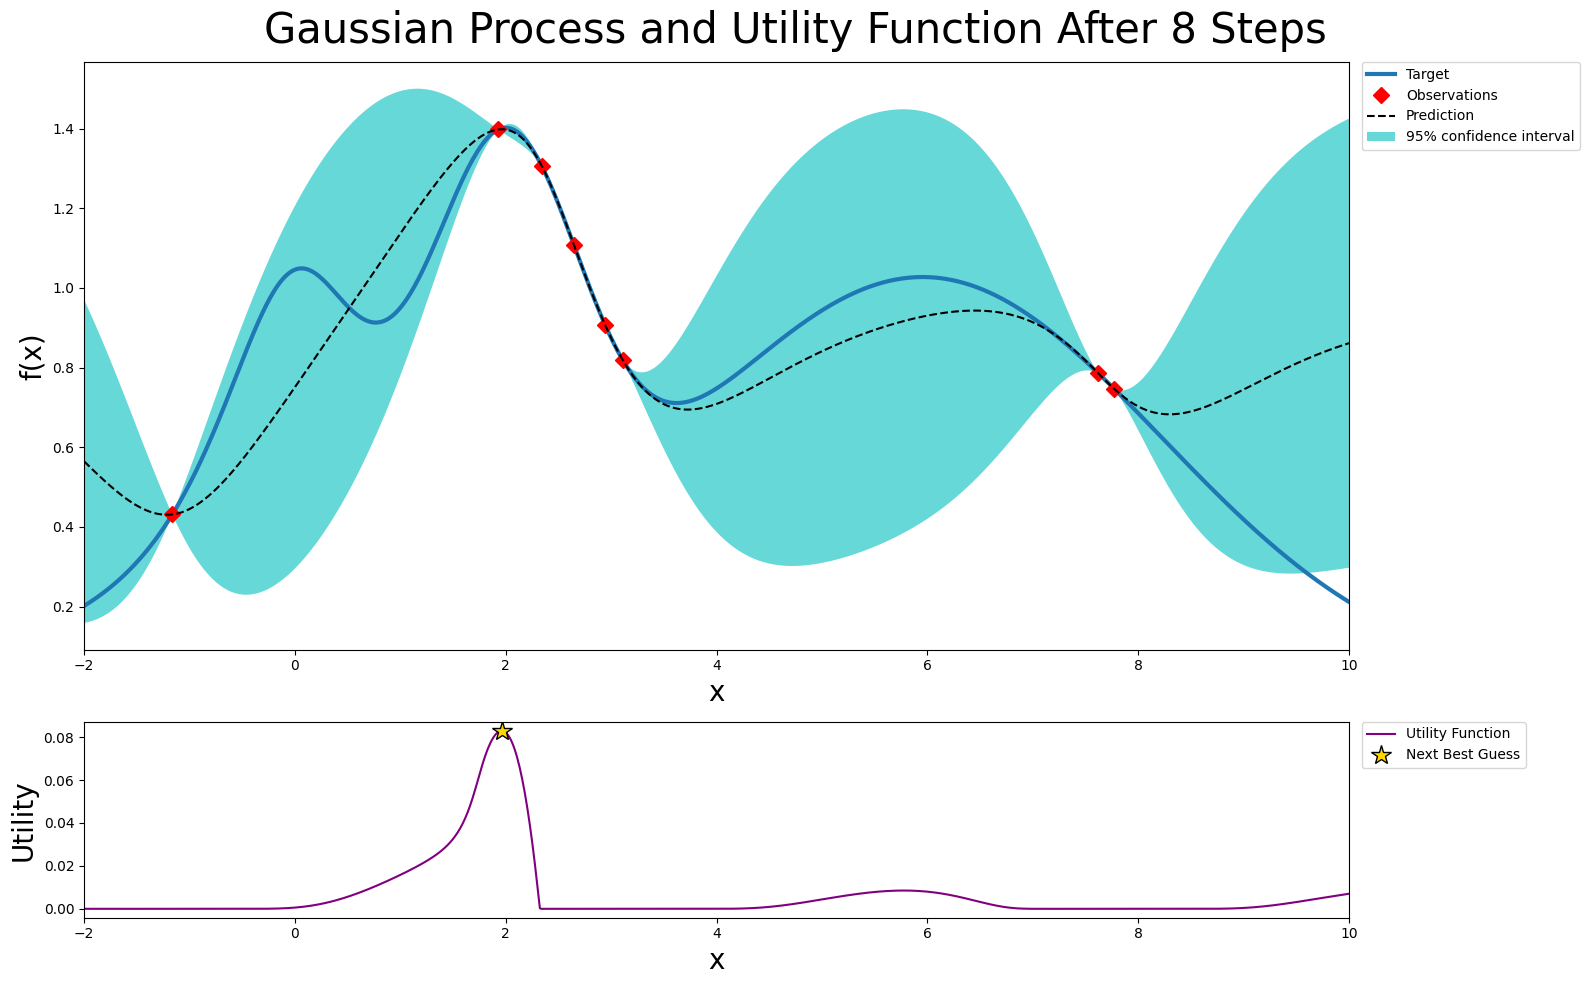

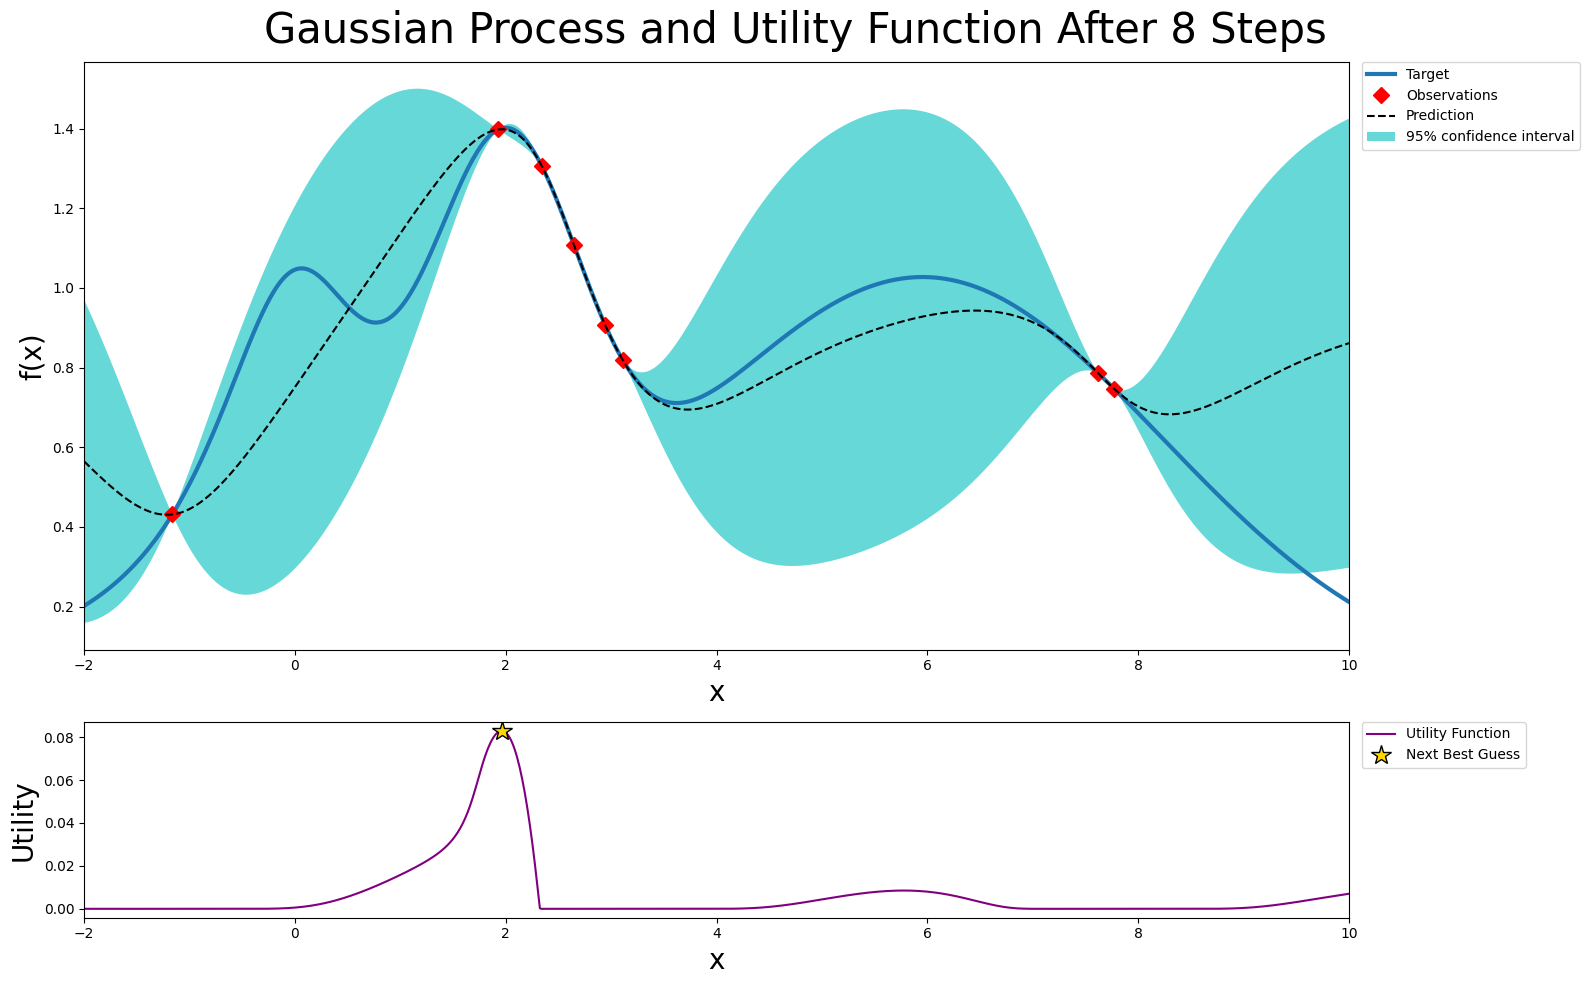

In [31]:
ei = ExpectedImprovement(xi=0.01, random_state=27)

optimizer_ei = BayesianOptimization(
    f=target_function,
    pbounds={"x": (-2, 10)},
    acquisition_function=ei,
    random_state=27,
)

optimizer_ei.maximize(init_points=2, n_iter=6)

print("\nExpected Improvement Acquisition Function Results:")
plot_gp(optimizer_ei, x, y)

This method gives a fairly good result. The best point is close to the optimum. The result is similar to UCB (kappa = 2.5); if the algorithm runs for 8 iterations,  
it finds the minimum. However, if we compare EI and UCB (kappa = 2.5) after 7 iterations, UCB performs slightly better. Still, compared to the other acquisition  
functions tested, EI shows better performance.  

Exercise 4: Theoretical Questions
--------------------------------
1. Why is Bayesian Optimization particularly useful for expensive-to-evaluate functions?
2. Compare and contrast the different acquisition functions discussed in this tutorial.
3. What are the limitations of Bayesian Optimization?

1. Bayesian optimization is particularly useful for expensive-to-evaluate functions because it builds a surrogate model to guide the optimization process.  
Thanks to intelligent sampling methods, it explores the solution space efficiently to find the maximum. This approach does not require evaluating many points  
to find an optimal solution.  

2. I would like to compare UCB and EI, the result below:

| Feature                      | UCB                                  | Expected Improvement (EI)                          |
|-----------------------------|---------------------------------------|----------------------------------------------------|
| Type                        | Based on mean and std                             | Based on expectation                               |
| Exploration/Exploitation    | Manual (via `κ`)                      | Automatic, depends on data                         |
| Control Parameter           | `κ` – exploration coefficient         | `ξ` – improvement margin                           |
| Performance                 | Good with balance                     | Better when fast convergence to maximum is needed  |


This method is sequential, which makes it difficult to parallelize. Algorithms like exhaustive search are easy to parallelize, but Bayesian Optimization is not.  
The results are sensitive to the type of acquisition function used and its hyperparameters.  
The Gaussian Process model is computationally expensive, with complexity of O(n^3).  
This method is designed for continuous variables — for discrete variables, additional considerations are needed.  

